(c) 2021, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from datetime import datetime

In [3]:
# import physiobank ecg data
data_physionet = pd.read_csv('./ECG_data/physionet/ecg_id_01_1.csv', sep=",", header=2)
data_physionet.columns = ['time', 'ECG I', 'ECG I filtered']

In [350]:
t_max = 20 # s
len_series = len(data_physionet['ECG I'])
sample_frequency = len_series / t_max
t = np.linspace(0, t_max, len_series)

<IPython.core.display.Javascript object>


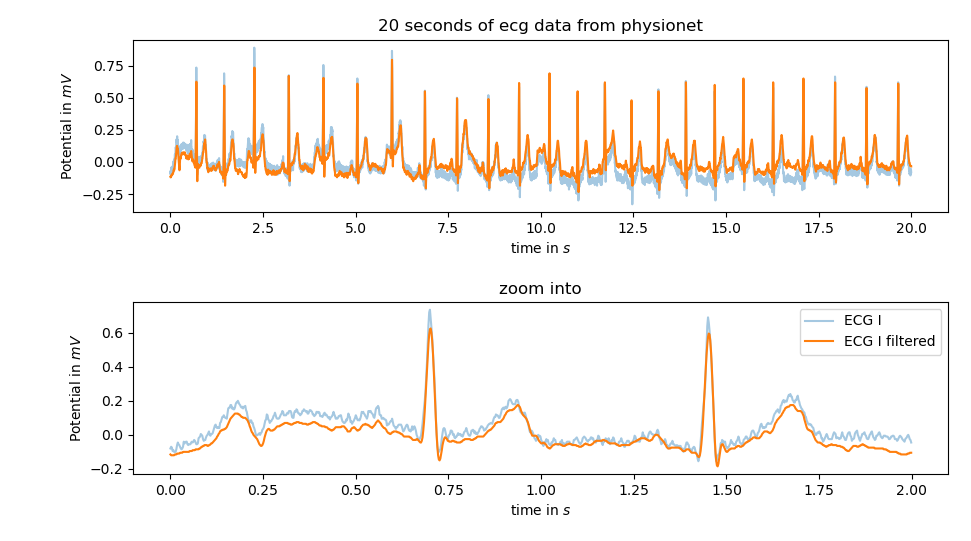

In [358]:
%matplotlib notebook
plt.subplot(2, 1, 1)
plt.title('20 seconds of ecg data from physionet')
plt.plot(t, data_physionet['ECG I'], alpha=.4, label='ECG I')
plt.plot(t, data_physionet['ECG I filtered'], label='ECG I filtered')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.subplot(2, 1, 2)
plt.title('zoom into')
plt.plot(t[:1000], data_physionet['ECG I'][:1000], alpha=.4, label='ECG I')
plt.plot(t[:1000], data_physionet['ECG I filtered'][:1000], label='ECG I filtered')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.legend()
plt.tight_layout()
plt.show()

The starting value and the ending value of the above series by PhysioBank differ neglectable.

In [38]:
print(data_physionet['ECG I filtered'][0] - data_physionet['ECG I filtered'][len(data_physionet['ECG I filtered'])-1])

-0.08


# Fourier analysis
Examining to obtain the base frequency $\omega_0$ of the signal. Since the signal is periodic and shows a noticable peak ata the R-waves, the base frequency must show a high amplitude in the fourier transform. From the base frequency one can receive the period $T$ of the signal via $\omega_0=\frac{2\pi}{T}$.

In [353]:
sp = np.fft.rfft(data_physionet['ECG I filtered'])
freq = np.fft.rfftfreq(t.shape[-1])
freq = freq * 499.95

<IPython.core.display.Javascript object>


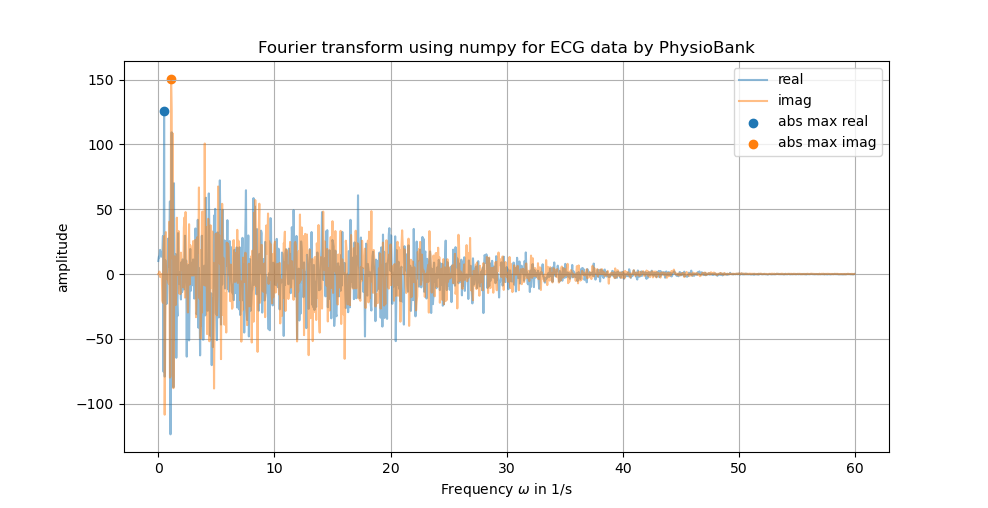

In [359]:
%matplotlib notebook

max_value = 1200

plt.plot(freq[:max_value], sp.real[:max_value], alpha=.5, label='real')
plt.plot(freq[:max_value], sp.imag[:max_value], alpha=.5, label='imag')

m_real = max(abs(sp.real))
f_real = freq[np.where(sp.real == m_real)]
plt.scatter(f_real, m_real, label='abs max real')
m_imag = max(abs(sp.imag))
f_imag = freq[np.where(sp.imag == m_imag)]
plt.scatter(f_imag, m_imag, label='abs max imag')

plt.title('Fourier transform using numpy for ECG data by PhysioBank')
plt.ylabel('amplitude')
plt.xlabel('Frequency $\omega$ in 1/s')
plt.legend()
plt.grid()
plt.show()

In [363]:
f_real[0]

0.5

In [364]:
f_imag[0]

1.0999999999999999

The base frequencies (imaginary and real) could be determined:

$$
\omega_{0,real} = 0.5\text{ Hz}
\\
\omega_{0,imag} \approx 1.1\text{ Hz}
$$

Which makes totally sense considering that a heart usually beats at around $1 bps$. In the used ECG series the heart shows a beat at around $72 bpm$ which equals $1.2 bps$.

In [365]:
2 * np.pi / 0.5

12.566370614359172

In [366]:
2 * np.pi / 1.099

5.717184082965956

Which means for the period $T = \frac{2\pi}{\omega_0}$

$$
T_{real} = 12.566\text{ s}
\\
T_{imag} = 5.717\text{ s}
$$

$T' = T \cdot f_{sample}$:

$$
T'_{real} = 6282.567\text{ t-steps}
\\
T'_{imag} = 2858.306\text{ t-steps}
$$

# Fit to nonlinear oscillator
With the known period we can begin the reconstruction by fitting the time series to a nonlinear oscillator:

$$
\dot{y} = y
\\
\ddot{y} = f(y,\dot{y})
$$

In [14]:
def compute_2d_polynominal(grade):
    y_res = []
    ydot_res = []
    
    while grade > 0:
        o = compute_2d_polynominal_single_part(grade)
        y_res += o[0]
        ydot_res += o[1]
        
        grade -= 1

    return (y_res[::-1], ydot_res[::-1])

def compute_2d_polynominal_single_part(grade):
    y = [0, 1] # needs to be reversed at end
    ydot = [1, 0] # same
    
    if grade == 0:
        return ([], [])
    grade -= 1
    
    while grade > 0:
        grade -= 1
        y.append(y[-1] + 1)
        
        ydot = [el + 1 for el in ydot]
        ydot.append(0)
        
    return (y, ydot)

In [383]:
def solve_eqs_for_p_variable_grade_omega_periodic(y, ydot, z, grade=3, period=None):
    polynominal = compute_2d_polynominal(grade)
    rhs_without_measured = polynominal

    len_polynominal = len(polynominal[0])
    
    if period == None:
        period = len(y)
    c = - (2 * np.pi / period) ** 2 # <-------- -\omega_0^2 

    a = np.ones((len_polynominal, len_polynominal))
    b = np.ones((len_polynominal, 1))

    for i in range(len_polynominal):
        for j in range(len_polynominal):
            a[i][j] *= np.sum(y ** (polynominal[0][j] + polynominal[0][i]) * \
                              ydot ** (polynominal[1][j] + polynominal[1][i]))

    to_rhs = a[0, 1:]
    a = a[1:, 1:]

    for i in range(len_polynominal):
        b[i] *= np.sum(z * y ** polynominal[0][i] * ydot ** polynominal[1][i])
        if i > 0:
            b[i] -= c * to_rhs[i - 1] # <-------- -\omega_0^2 

    b = b[1:]
    
    return np.linalg.solve(a, b)

In [384]:
def convert_fit_coefficients_to_function_variable_grade(p, period):
    if type(p) != np.ndarray: return print('Wrong coefficient type:', type(p), 'Expected numpy.ndarray.')
    
    c = - (2 * np.pi / period) ** 2 # <-------- -\omega_0^2 
    
    len_polyn = len(p)
    grade = 0
    while len_polyn > 0:
        grade += 1
        len_polyn -= grade + 1

    print('Polynominal of grade %i detected' % (grade))

    y_poly, ydot_poly = compute_2d_polynominal(grade)

    def func(y, ydot):
        res = c * y # <-------- -\omega_0^2 
        for i in range(len(p)):
            res += p[i] * y ** y_poly[i+1] * ydot ** ydot_poly[i+1]

        return res

    return func

In [17]:
def five_point_derivate_periodic(series):
    ''' Returns the 1D second order upwind derivate of a one dimensional
    time series using reflecting boundary conditions.
    '''

    series = np.array(series)
    dx = 1
    d_pos = (- 3 * series \
             + 4 * np.roll(series, shift=-1, axis=0) \
             - np.roll(series, shift=-2, axis=0)
            ) / (2 * dx)
    d_neg = (+ 3 * series \
             - 4 * np.roll(series, shift=1, axis=0) \
             + np.roll(series, shift=2, axis=0)
            ) / (2 * dx)
    derivate = d_pos
    derivate[-3::] = d_neg[-3::]
    #print(d_pos)
    #print(d_neg)
    
    return derivate

In [441]:
grade = 3
index = 'ECG I filtered'
series = data_physionet[index]
period = 6282.567 #2858.306 #<-

p_1 = solve_eqs_for_p_variable_grade_omega_periodic(series, \
                                                    five_point_derivate_periodic(series), \
                                                    five_point_derivate_periodic(series),
                                                    grade, period=period)
p_2 = solve_eqs_for_p_variable_grade_omega_periodic(series, \
                                                    five_point_derivate_periodic(series), \
                                                    five_point_derivate_periodic(five_point_derivate_periodic( \
                                                                                            series)),
                                                    grade, period=period)

In [442]:
p_1 = convert_fit_coefficients_to_function_variable_grade(p_1, period)
p_2 = convert_fit_coefficients_to_function_variable_grade(p_2, period)

Polynominal of grade 3 detected
Polynominal of grade 3 detected


<IPython.core.display.Javascript object>


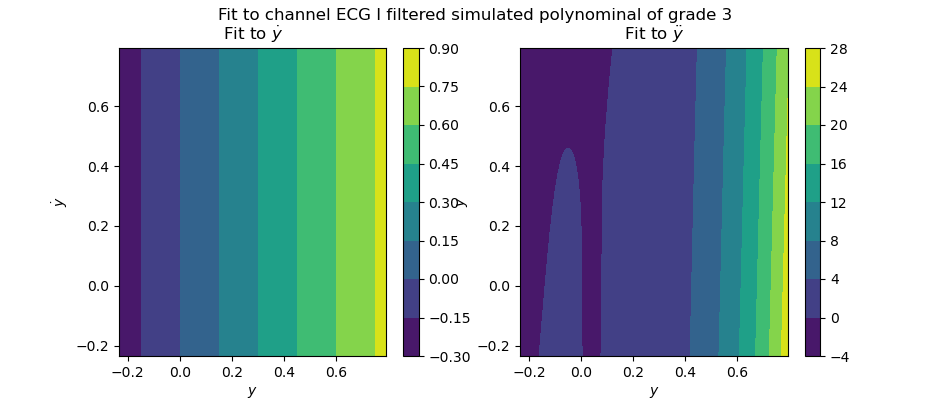

In [450]:
%matplotlib notebook

y = np.linspace(min(series), max(series), 100)
#y = np.linspace(-1, 1, 150)
ydot = y

fig = plt.figure(figsize=(9.5, 4))
fig.suptitle('Fit to channel %s simulated polynominal of grade %i' % (index, grade))

ax_1 = fig.add_subplot(1, 2, 1)
r_1 = [[np.sum(p_1(el, sel)) for sel in ydot] for el in y]
c = ax_1.contourf(y, ydot, r_1)
fig.colorbar(c)
ax_1.set_xlabel('$y$')
ax_1.set_ylabel('$\dot{y}$')
ax_1.set_title('Fit to $\dot{y}$')

ax_2 = fig.add_subplot(1, 2, 2)
r_2 = [[np.sum(p_2(el, sel)) for sel in ydot] for el in y]
c = ax_2.contourf(y, ydot, r_2)
fig.colorbar(c)
ax_2.set_xlabel('$y$')
ax_2.set_ylabel('$\dot{y}$')
ax_2.set_title('Fit to $\ddot{y}$')

plt.show()

<IPython.core.display.Javascript object>


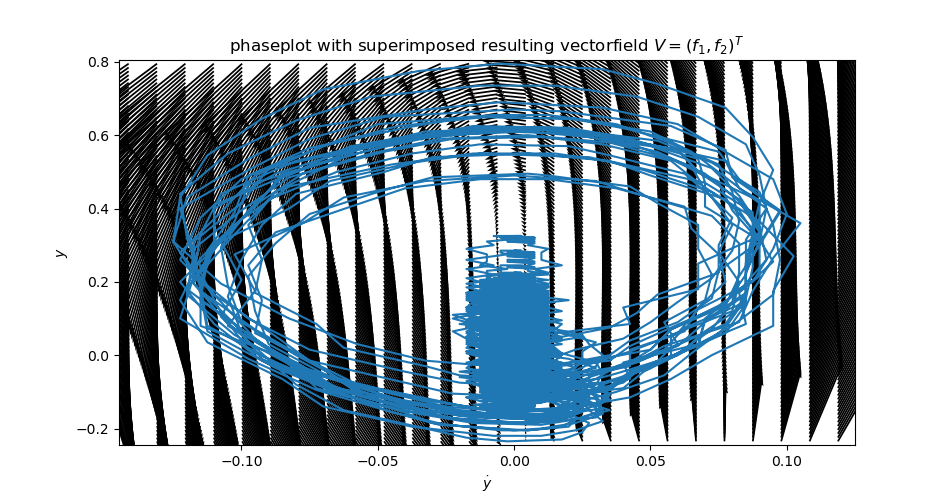

In [444]:
%matplotlib notebook
DEBUG = True
if DEBUG:
    fig = plt.figure(figsize=(9.5, 5))
    plt.plot(five_point_derivate_periodic(series), series)
    plt.ylabel('$y$')
    plt.xlabel('$\dot{y}$')
    plt.title('phaseplot with superimposed resulting vectorfield $V=(f_1,f_2)^T$')
    plt.quiver(ydot, y, r_2, r_1, scale=1)
    plt.ylim(np.min(series) - 0.01, np.max(series) + 0.01)
    plt.xlim(np.min(five_point_derivate_periodic(series)) - 0.02, \
             np.max(five_point_derivate_periodic(series)) + 0.02)
    plt.show()

# Solving the resulting ODE
tba.

In [445]:
def func_omega_periodic(t, x, fit_to_y, fit_to_ydot):
    ''' ECG common channel system
    '''
    y = [0, 0]
    
    #y[0] = fit_to_y(x[0], x[1])[0]
    y[0] = x[1]
    y[1] = fit_to_ydot(x[0], x[1])[0]
    return y

In [448]:
T = len(series)

ivp = [0, 0]
ivp[0] += series[0]
ivp[1] += five_point_derivate_periodic(series)[0]

sol = solve_ivp(func_omega_periodic, [0, T], [ivp[0], ivp[1]], dense_output=True, args=[p_1, p_2])

t = np.linspace(0, T, T)
y, ydot = sol.sol(t)

res = (t, y, ydot)

<IPython.core.display.Javascript object>


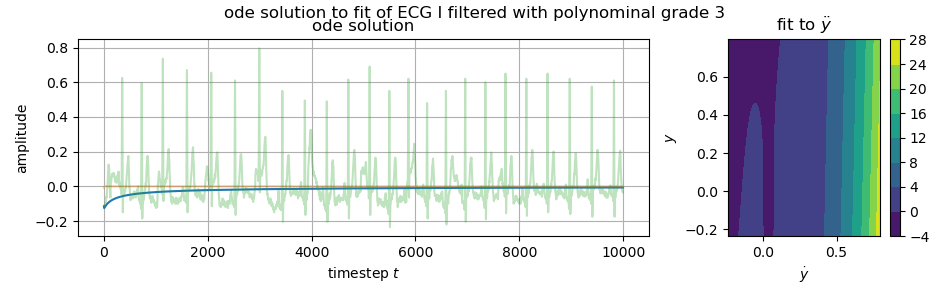

In [449]:
%matplotlib notebook

fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1]}, figsize=(9.5, 3))

max_index = -1
a0.plot(res[0][:max_index], res[1][:max_index], label='$y$')
a0.plot(res[0][:max_index], res[2][:max_index], label='$\dot{y}$', alpha=0.4)
a0.plot(series[:max_index], label='original $y$', alpha=0.3)
a0.set_xlabel('timestep $t$')
a0.set_ylabel('amplitude')
a0.grid()
#a0.legend()
a0.set_title('ode solution')

y_ = np.linspace(min(series), max(series), 100)
ydot_ = y_
#r_2 = [[np.sum(p_2(el, sel)) for sel in ydot_] for el in y_]
c = a1.contourf(y_, ydot_, r_2)
fig.colorbar(c)
a1.set_title('fit to $\ddot{y}$')
a1.set_xlabel('$\dot{y}$')
a1.set_ylabel('$y$')

fig.suptitle('ode solution to fit of %s with polynominal grade %i' % (index, grade))

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


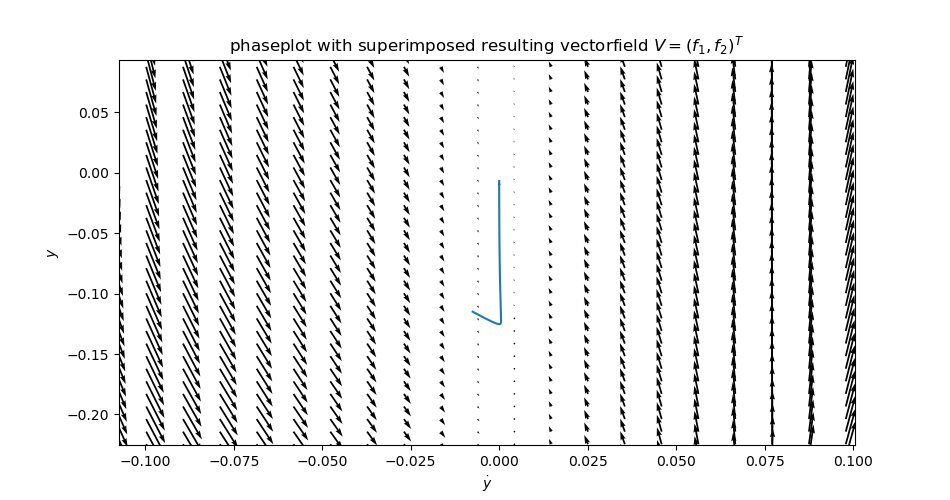

In [451]:
%matplotlib notebook
DEBUG = True
if DEBUG:
    fig = plt.figure(figsize=(9.5, 5))
    plt.plot(res[2], res[1])
    plt.ylabel('$y$')
    plt.xlabel('$\dot{y}$')
    plt.title('phaseplot with superimposed resulting vectorfield $V=(f_1,f_2)^T$')
    plt.quiver(ydot, y, r_2, r_1, scale=2)
    plt.ylim(np.min(res[1]) - 0.1, np.max(res[1]) + 0.1)
    plt.xlim(np.min(res[2]) - 0.1, \
             np.max(res[2]) + 0.1)
    plt.show()